# Initial Imports and Constants

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import lightkurve as lk
from lightkurve import search_targetpixelfile
import pandas as pd
import os
import batman
from scipy.stats import norm
import matplotlib
import os

In [2]:
### Define data directory
working_dir = os.getcwd()
data_dir = os.path.join(working_dir, "data")
print(f"Data directory: {data_dir}")

Data directory: /Users/pentrican10/Projects/tess-resonant-systems/data


In [141]:
### switch to mask out transits
mask_transits = True
### set range for search: [#hours] * [days per hour]
ttv_hour = 2* 0.0416667 # 1 hour to days

In [4]:
### function to convert times from TESS to Petigura offset
TESS_offset = 2457000
petigura_offset = 2454833
def convert_time_t2p(times):
    ### TESS offset 
    BTJD = times + TESS_offset
    new_time = BTJD - petigura_offset
    return new_time

In [5]:
# List of known planet periods and epoch guesses (from paper)
known_planets = [
    {"name": "d", "period": 3.97664, "t0": 1357.8398},
    {"name": "e", "period": 7.90754, "t0": 1354.5659},
    {"name": "f", "period": 12.1621839, "t0": 1360.0754},
    {"name": "b", "period": 17.667087, "t0": 1360.6641},
    {"name": "c", "period":  29.79749, "t0":  1370.1037},
]


# Get data

In [6]:
lc_collection = lk.search_lightcurve("TOI 174", author='SPOC').download_all()


In [7]:
clean_lcs = [lc[lc.quality == 0] for lc in lc_collection]


In [8]:
# Step 2: Normalize, flatten, and remove outliers
processed_lcs = [
    lc.normalize().flatten(window_length=401).remove_outliers(sigma=5)
    for lc in clean_lcs
]

In [9]:
# Step 3: Stitch into one combined light curve
combined_lc = processed_lcs[0]
for lc in processed_lcs[1:]:
    combined_lc = combined_lc.append(lc)


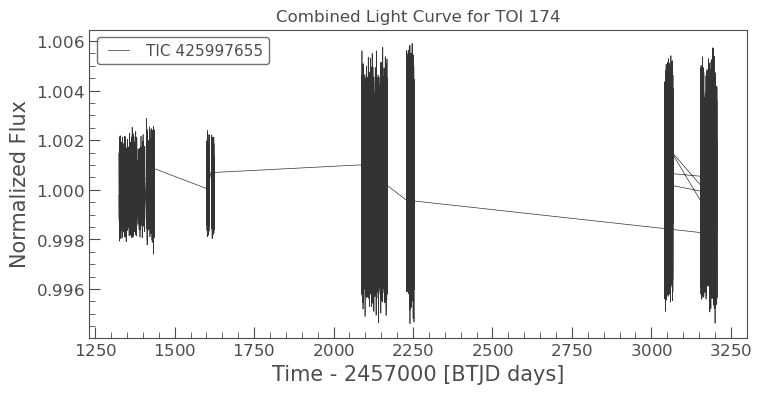

In [10]:
combined_lc.plot()
plt.title("Combined Light Curve for TOI 174")
plt.show()

In [142]:
# Extract useful data arrays
time = combined_lc.time.value
flux = combined_lc.flux.value
flux_err = combined_lc.flux_err.value
print(time)
print(flux)

[1325.29658484 1325.29797375 1325.29936267 ... 3206.30610315 3206.30749203
 3206.30888092]
[0.99978624 0.99906917 0.99895675 ... 0.99949611 1.00016749 1.00192988]


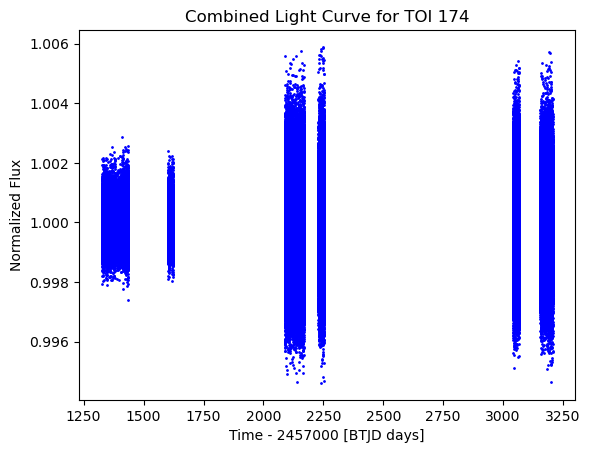

In [144]:
plt.scatter(time, flux, s=1, c='b')
plt.title('Combined Light Curve for TOI 174')
plt.xlabel('Time - 2457000 [BTJD days]')
plt.ylabel('Normalized Flux')
plt.show()

# BLS Runs

## BLS 1

`period` contains 279041 points.Periodogram is likely to be large, and slow to evaluate. Consider setting `frequency_factor` to a higher value.


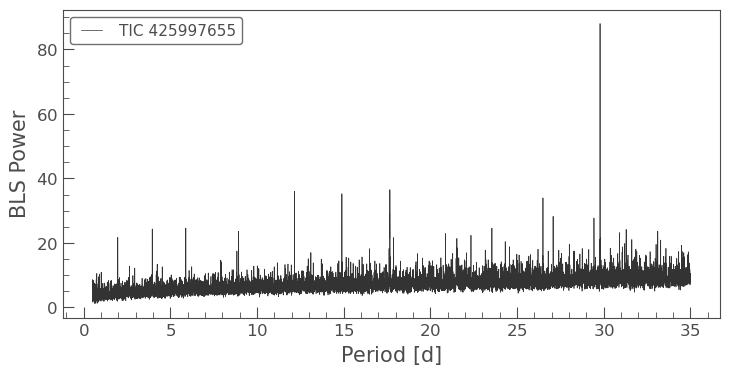

In [13]:
bls_1 = combined_lc.to_periodogram(method='bls', period=np.linspace(0.5, 35, 10000), frequency_factor=500)
bls_1.plot()
plt.show()


`period` contains 279041 points.Periodogram is likely to be large, and slow to evaluate. Consider setting `frequency_factor` to a higher value.


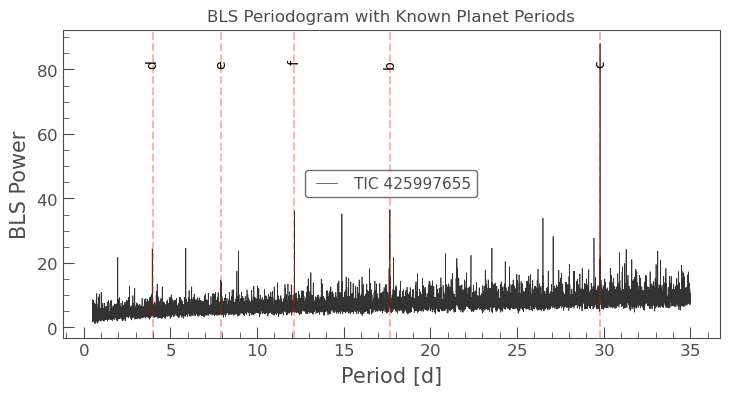

In [14]:
# BLS periodogram
bls_1 = combined_lc.to_periodogram(
    method='bls',
    period=np.linspace(0.5, 35, 10000),
    frequency_factor=500
)

# Plot the BLS periodogram
bls_1.plot()
plt.title("BLS Periodogram with Known Planet Periods")

# Overlay vertical lines at known periods
for planet in known_planets:
    plt.axvline(planet["period"], color='red', linestyle='--', alpha=0.3)
    plt.text(
        planet["period"], plt.ylim()[1]*0.9, f"{planet['name']}",
        rotation=90, color='black', fontsize=10, ha='center', va='top'
    )

plt.show()

In [15]:
best_period = bls_1.period_at_max_power
duration = bls_1.duration_at_max_power
t0 = bls_1.transit_time_at_max_power

print(f"Best candidate period: {best_period.value:.5f} days")
print(f"Best candidate t0: {t0.value:.5f} days")

Best candidate period: 29.79688 days
Best candidate t0: 1340.31158 days


In [16]:
import numpy as np
from scipy.signal import find_peaks

# 1. Access full power array
powers = bls_1.power.value
periods = bls_1.period.value
durations = bls_1.duration.value
t0s = bls_1.transit_time.value

# 2. Find all peaks in the BLS power spectrum
peaks, _ = find_peaks(powers)

# 3. Sort peaks by power (descending)
sorted_peaks = peaks[np.argsort(powers[peaks])[::-1]]

# 4. Get top 3 signal indices
top_indices = sorted_peaks[:7]

# 5. Extract their periods, durations, and t0s
top_periods = periods[top_indices]
top_durations = durations[top_indices]
top_t0s = t0s[top_indices]
top_powers = powers[top_indices]

# 6. Print results
for i in range(7):
    print(f"Signal {i+1}:")
    print(f"  Period:   {top_periods[i]:.5f} days")
    print(f"  T0:       {top_t0s[i]:.5f}")
    print(f"  Duration: {top_durations[i]:.5f} days")
    print(f"  Power:    {top_powers[i]:.5f}")
    print("-" * 30)


Signal 1:
  Period:   29.79688 days
  T0:       1340.31158
  Duration: 0.10000 days
  Power:    88.01510
------------------------------
Signal 2:
  Period:   17.66547 days
  T0:       1325.34658
  Duration: 0.10000 days
  Power:    36.51613
------------------------------
Signal 3:
  Period:   12.16217 days
  T0:       1335.75158
  Duration: 0.10000 days
  Power:    36.04969
------------------------------
Signal 4:
  Period:   14.89829 days
  T0:       1325.42658
  Duration: 0.05000 days
  Power:    35.24893
------------------------------
Signal 5:
  Period:   26.50180 days
  T0:       1334.14158
  Duration: 0.05000 days
  Power:    33.95707
------------------------------
Signal 6:
  Period:   17.65512 days
  T0:       1325.36158
  Duration: 0.10000 days
  Power:    29.15584
------------------------------
Signal 7:
  Period:   17.67927 days
  T0:       1342.95658
  Duration: 0.05000 days
  Power:    28.83856
------------------------------


In [33]:
# Create a cadence mask using the BLS parameters
planet_1_mask = bls_1.get_transit_mask(period=best_period,
                                     transit_time=t0,
                                     duration=duration*1.5)

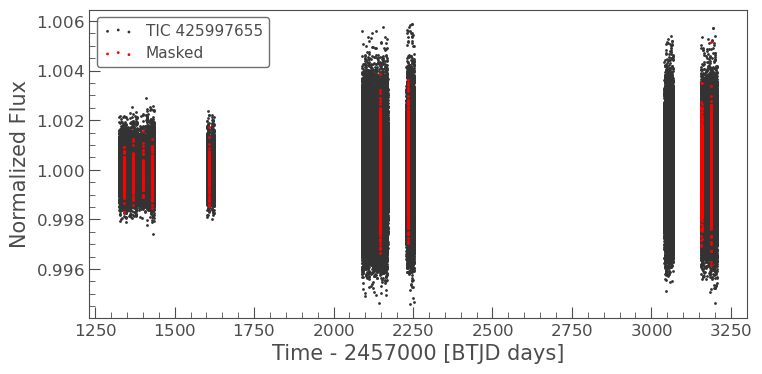

In [34]:
masked_lc_1 = combined_lc[~planet_1_mask]
ax = masked_lc_1.scatter();
combined_lc[planet_1_mask].scatter(ax=ax, c='r', label='Masked')
# plt.xlim(2144, 2145)
plt.show()

In [35]:
# Create a BLS model using the BLS parameters
planet_1_model = bls_1.get_transit_model(period=best_period,
                                       transit_time=t0,
                                       duration=duration)


In [36]:
# ax = combined_lc.fold(best_period, t0).scatter()
# planet_1_model.fold(best_period, t0).plot(ax=ax, c='r', lw=2)
# ax.set_xlim(-1, 1)
# plt.show()

## BLS 2

`period` contains 137498 points.Periodogram is likely to be large, and slow to evaluate. Consider setting `frequency_factor` to a higher value.


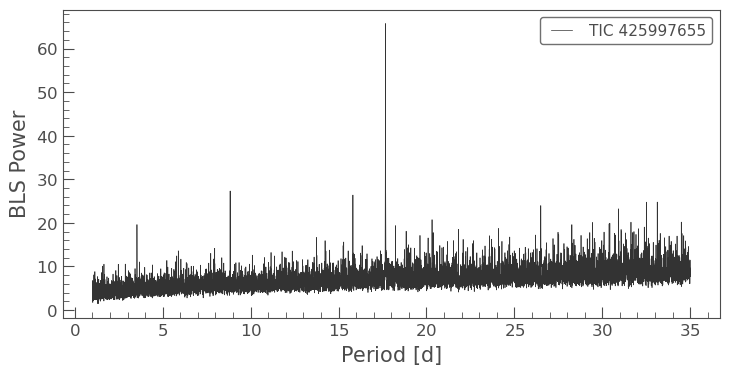

In [37]:
period = np.linspace(1, 35, 10000)
bls_2 = masked_lc_1.to_periodogram('bls', period=period, frequency_factor=500)
bls_2.plot()
plt.show()

In [38]:
planet_2_period = bls_2.period_at_max_power
planet_2_t0 = bls_2.transit_time_at_max_power
planet_2_dur = bls_2.duration_at_max_power

print(f"Best candidate period 2: {planet_2_period.value:.5f} days")
print(f"Best candidate t0 2: {planet_2_t0.value:.5f} days")

Best candidate period 2: 17.66847 days
Best candidate t0 2: 1342.96158 days


In [65]:
# ax = masked_lc_1.fold(planet_2_period, planet_2_t0).scatter()
# masked_lc_1.fold(planet_2_period, planet_2_t0).bin(.1).plot(ax=ax, c='r', lw=2,
#                                                           label='Binned Flux')
# ax.set_xlim(-5, 5)
# plt.show()

In [60]:
planet_2_mask = bls_2.get_transit_mask(period=planet_2_period,
                                     transit_time=planet_2_t0,
                                     duration=planet_2_dur*1.5)

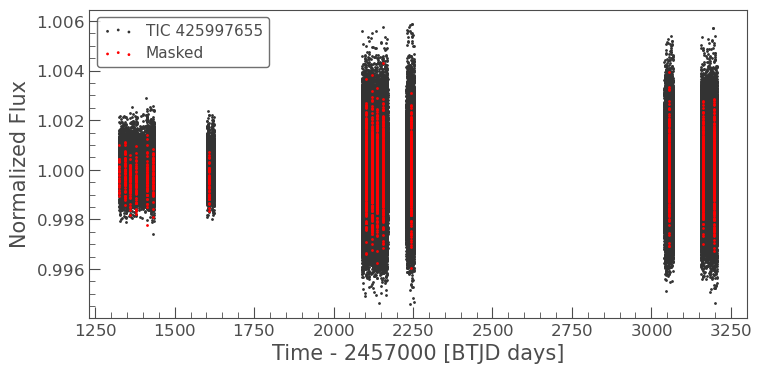

In [61]:
masked_lc_2 = masked_lc_1[~planet_2_mask]
ax = masked_lc_2.scatter();
masked_lc_1[planet_2_mask].scatter(ax=ax, c='r', label='Masked')
# plt.xlim(2144, 2145)
plt.show()

In [62]:
planet_2_model = bls_2.get_transit_model(period=planet_2_period,
                                       transit_time=planet_2_t0,
                                       duration=planet_2_dur)

## BLS 3

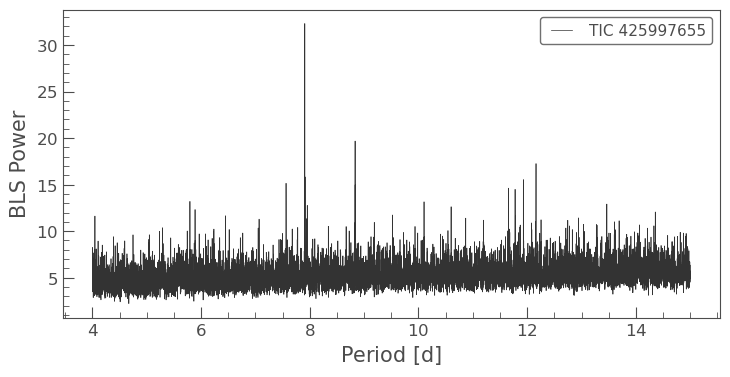

In [66]:
### start period search at 4days to try to find planet e before d
period = np.linspace(4, 15, 10000)
bls_3 = masked_lc_2.to_periodogram('bls', period=period, frequency_factor=500)
bls_3.plot()
plt.show()

In [68]:
planet_3_period = bls_3.period_at_max_power
planet_3_t0 = bls_3.transit_time_at_max_power
planet_3_dur = bls_3.duration_at_max_power

print(f"Best candidate period 3: {planet_3_period.value:.5f} days")
print(f"Best candidate t0 3: {planet_3_t0.value:.5f} days")

Best candidate period 2: 7.90759 days
Best candidate t0 2: 1330.83631 days


In [69]:
planet_3_mask = bls_3.get_transit_mask(period=planet_3_period,
                                     transit_time=planet_3_t0,
                                     duration=planet_3_dur*1.5)


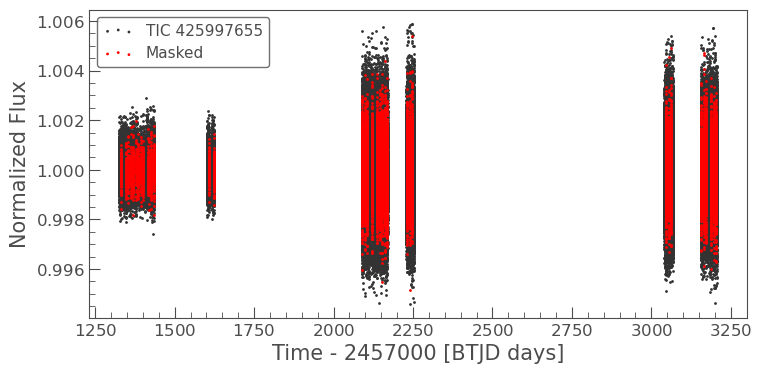

In [70]:
masked_lc_3 = masked_lc_2[~planet_3_mask]
ax = masked_lc_3.scatter();
masked_lc_2[planet_3_mask].scatter(ax=ax, c='r', label='Masked')
# plt.xlim(2144, 2145)
plt.show()

In [71]:
planet_3_model = bls_3.get_transit_model(period=planet_3_period,
                                       transit_time=planet_3_t0,
                                       duration=planet_3_dur)

## BLS 4

`period` contains 132101 points.Periodogram is likely to be large, and slow to evaluate. Consider setting `frequency_factor` to a higher value.


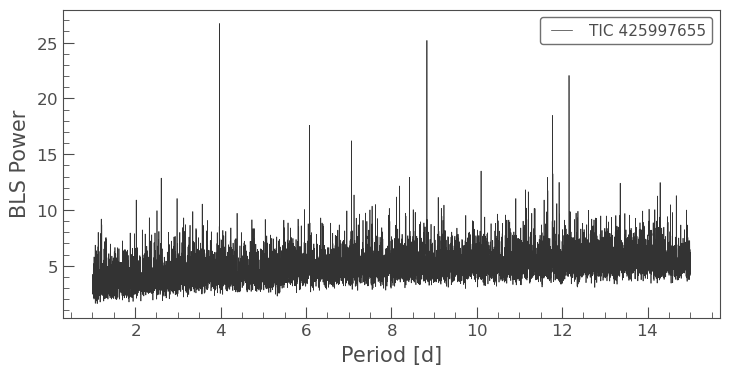

In [92]:
period = np.linspace(1, 15, 10000)
bls_4 = masked_lc_3.to_periodogram('bls', period=period, frequency_factor=500)
bls_4.plot()
plt.show()

In [93]:
planet_4_period = bls_4.period_at_max_power
planet_4_t0 = bls_4.transit_time_at_max_power
planet_4_dur = bls_4.duration_at_max_power

print(f"Best candidate period 4: {planet_4_period.value:.5f} days")
print(f"Best candidate t0 4: {planet_4_t0.value:.5f} days")

Best candidate period 4: 3.97670 days
Best candidate t0 4: 1326.01131 days


In [94]:
planet_4_mask = bls_4.get_transit_mask(period=planet_4_period,
                                     transit_time=planet_4_t0,
                                     duration=planet_4_dur*1.5)


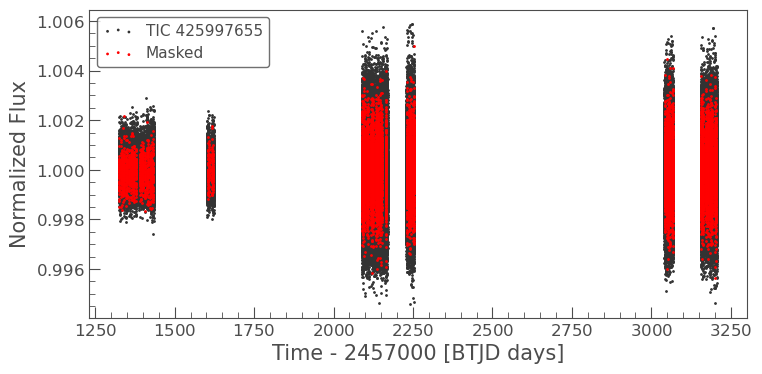

In [95]:
masked_lc_4 = masked_lc_3[~planet_4_mask]
ax = masked_lc_4.scatter();
masked_lc_3[planet_4_mask].scatter(ax=ax, c='r', label='Masked')
# plt.xlim(2144, 2145)
plt.show()

In [96]:
planet_4_model = bls_4.get_transit_model(period=planet_4_period,
                                       transit_time=planet_4_t0,
                                       duration=planet_4_dur)

## BLS 5

`period` contains 132101 points.Periodogram is likely to be large, and slow to evaluate. Consider setting `frequency_factor` to a higher value.


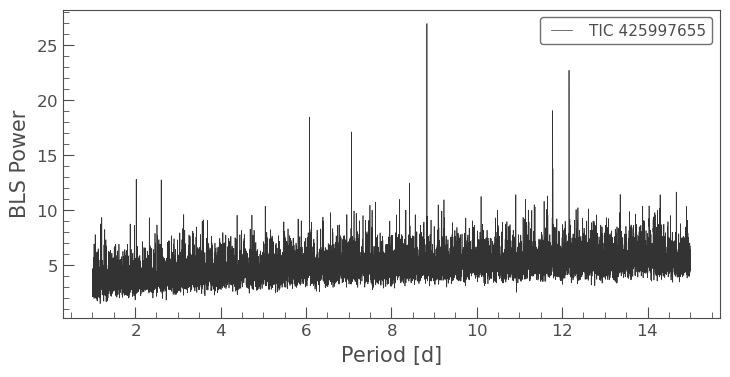

In [111]:
period = np.linspace(1, 15, 10000)
bls_5 = masked_lc_4.to_periodogram('bls', period=period, frequency_factor=500)
bls_5.plot()
plt.show()

In [112]:
planet_5_period = bls_5.period_at_max_power
planet_5_t0 = bls_5.transit_time_at_max_power
planet_5_dur = bls_5.duration_at_max_power

print(f"Best candidate period 5: {planet_5_period.value:.5f} days")
print(f"Best candidate t0 5: {planet_5_t0.value:.5f} days")

Best candidate period 5: 8.83378 days
Best candidate t0 5: 1334.14631 days


In [113]:
planet_5_mask = bls_5.get_transit_mask(period=planet_5_period,
                                     transit_time=planet_5_t0,
                                     duration=planet_5_dur*1.5)


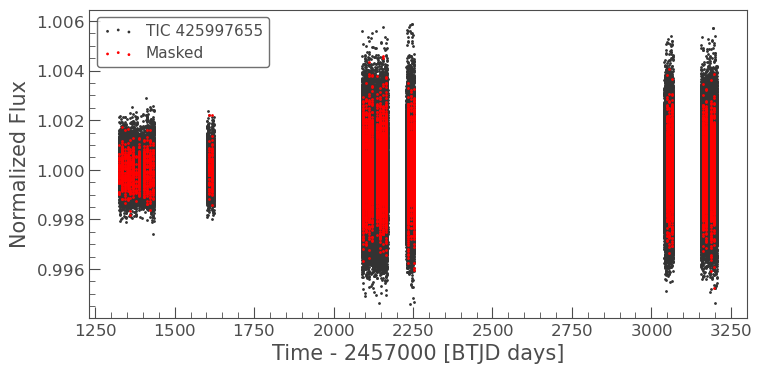

In [114]:
masked_lc_5 = masked_lc_4[~planet_5_mask]
ax = masked_lc_5.scatter();
masked_lc_4[planet_5_mask].scatter(ax=ax, c='r', label='Masked')
# plt.xlim(2144, 2145)
plt.show()

In [115]:
planet_5_model = bls_5.get_transit_model(period=planet_5_period,
                                       transit_time=planet_5_t0,
                                       duration=planet_5_dur)

## BLS 6

`period` contains 132093 points.Periodogram is likely to be large, and slow to evaluate. Consider setting `frequency_factor` to a higher value.


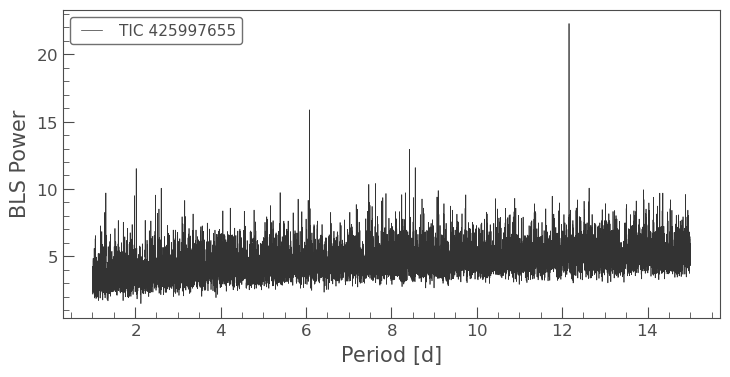

In [122]:
period = np.linspace(1, 15, 10000)
bls_6 = masked_lc_5.to_periodogram('bls', period=period, frequency_factor=500)
bls_6.plot()
plt.show()

In [124]:
planet_6_period = bls_6.period_at_max_power
planet_6_t0 = bls_6.transit_time_at_max_power
planet_6_dur = bls_6.duration_at_max_power

print(f"Best candidate period 6: {planet_6_period.value:.5f} days")
print(f"Best candidate t0 6: {planet_6_t0.value:.5f} days")

Best candidate period 6: 12.16192 days
Best candidate t0 6: 1335.78325 days


In [125]:
planet_6_mask = bls_6.get_transit_mask(period=planet_6_period,
                                     transit_time=planet_6_t0,
                                     duration=planet_6_dur*1.5)


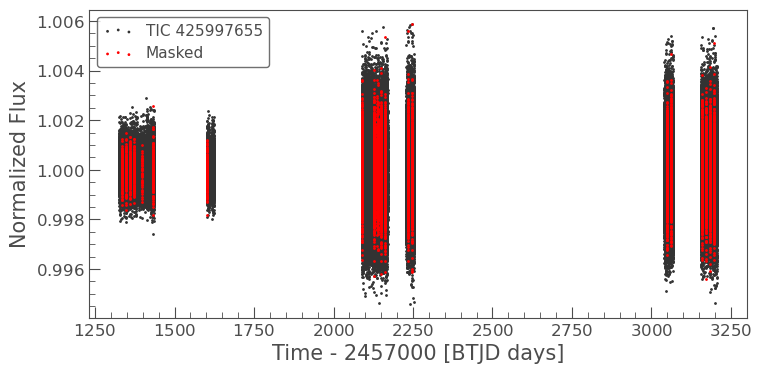

In [126]:
masked_lc_6 = masked_lc_5[~planet_6_mask]
ax = masked_lc_6.scatter();
masked_lc_5[planet_6_mask].scatter(ax=ax, c='r', label='Masked')
# plt.xlim(2144, 2145)
plt.show()

In [127]:
planet_6_model = bls_6.get_transit_model(period=planet_6_period,
                                       transit_time=planet_6_t0,
                                       duration=planet_6_dur)

## Transit models

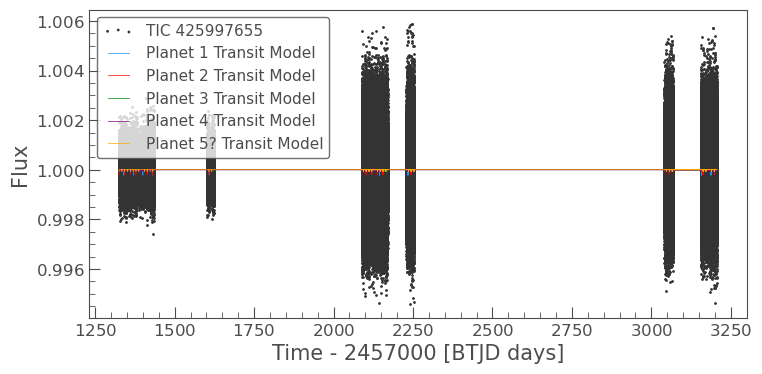

In [116]:
ax = combined_lc.scatter();
planet_1_model.plot(ax=ax, c='dodgerblue', label='Planet 1 Transit Model');
planet_2_model.plot(ax=ax, c='r', label='Planet 2 Transit Model');
planet_3_model.plot(ax=ax, c='g', label='Planet 3 Transit Model');
planet_4_model.plot(ax=ax, c='purple', label='Planet 4 Transit Model');
planet_5_model.plot(ax=ax, c='orange', label='Planet 5? Transit Model');
planet_6_model.plot(ax=ax, c='pink', label='Planet 6 Transit Model');

# plt.xlim(1340,1345)
# plt.ylim(0.998,1.002)
plt.show()

## Finding transit guess times based on models 

In [131]:
from scipy.signal import find_peaks

# Find all local minima (i.e., transit dips)
peaks_1, _ = find_peaks(-planet_1_model.flux.value, prominence=1e-5)
transit_times_1 = planet_1_model.time.value[peaks_1]
fluxes_1 = planet_1_model.flux.value[peaks_1]

print("Planet 1 transit dip times and depths:")
# for t, f in zip(transit_times_1, fluxes_1):
#     print(f"Time: {t:.5f}, Flux: {f:.6f}")
print(transit_times_1)

Planet 1 transit dip times and depths:
[1340.3107512  1370.10829085 1399.90407569 1429.70088536 1608.48344476
 2144.82755463 2144.82720741 2234.21806242 2234.2167893  3187.71818424
 3157.92077795 3157.92089369 3187.71714257]


In [132]:
# Find all local minima (i.e., transit dips)
peaks_2, _ = find_peaks(-planet_2_model.flux.value, prominence=1e-5)
transit_times_2 = planet_2_model.time.value[peaks_2]
fluxes_2 = planet_2_model.flux.value[peaks_2]

print("Planet 2 transit dip times and depths:")
# for t, f in zip(transit_times_2, fluxes_2):
#     print(f"Time: {t:.5f}, Flux: {f:.6f}")
print(transit_times_2)

Planet 2 transit dip times and depths:
[1342.96079611 1360.62906366 1378.29720847 1413.63448509 1431.3036323
 1607.98760338 2120.37453373 2138.04337769 2155.71163586 2102.70601228
 2120.37326059 2138.04256752 2155.71036274 2102.70520208 2244.05326656
 2244.05268787 3198.14996101 3056.8028417  3162.81345709 3056.8020315
 3162.81264689 3198.15053972]


In [133]:
# Find all local minima (i.e., transit dips)
peaks_3, _ = find_peaks(-planet_3_model.flux.value, prominence=1e-6)
transit_times_3 = planet_3_model.time.value[peaks_3]
fluxes_3 = planet_3_model.flux.value[peaks_3]

print("Planet 3 transit dip times and depths:")
# for t, f in zip(transit_times_3, fluxes_3):
#     print(f"Time: {t:.5f}, Flux: {f:.6f}")
print(transit_times_3)
print(len(transit_times_3))

Planet 3 transit dip times and depths:
[1330.83558863 1346.65113076 1354.55816433 1362.46796816 1370.37357022
 1378.24443066 1386.1888696  1394.09578256 1402.00544824 1417.81914909
 1425.7259561  1433.638307   1607.60148599 1623.41707082 2121.5958245
 2137.41051507 2145.3192155  2153.2251089  2161.13353005 2169.04099945
 2089.96542112 2097.87265364 2105.78009927 2121.5940884  2137.40924194
 2145.31747941 2153.22568759 2161.1324884  2169.04065223 2089.96484241
 2097.87184345 2105.77882612 2232.30097789 2240.20982058 2248.11638065
 2232.30155658 2240.20970485 2248.11649638 3189.12027728 3197.02796253
 3204.93562005 3046.78398159 3054.69123128 3062.59876005 3157.48951889
 3165.39752207 3173.30529189 3046.78247694 3054.69088405 3062.59794986
 3157.48894018 3173.30448169 3189.11993006 3197.02692086 3204.93527283]
55


In [134]:
# Find all local minima (i.e., transit dips)
peaks_4, _ = find_peaks(-planet_4_model.flux.value, prominence=1e-6)
transit_times_4 = planet_4_model.time.value[peaks_4]
fluxes_4 = planet_4_model.flux.value[peaks_4]

print("Planet 4 transit dip times and depths:")
# for t, f in zip(transit_times_4, fluxes_4):
#     print(f"Time: {t:.5f}, Flux: {f:.6f}")

print(transit_times_4)
print(len(transit_times_4))

Planet 4 transit dip times and depths:
[1326.01048878 1329.98418282 1333.96342549 1337.94126973 1341.91772318
 1345.89417526 1349.87061823 1357.82486907 1361.80129609 1365.77771228
 1369.75412201 1373.73053123 1377.70831907 1389.63886144 1393.61523034
 1397.59159069 1401.56795187 1405.54569197 1413.49837569 1417.47609871
 1421.45103372 1425.42873889 1429.40505757 1433.38136795 1604.37921134
 1608.35566491 1616.30998285 1620.2864524  2117.374079   2121.35022385
 2125.32635697 2133.28162372 2137.25773913 2141.23407586 2145.21134644
 2149.18790991 2153.1447863  2165.09456057 2089.53787027 2093.51383157
 2097.49070739 2105.44421872 2109.42038152 2117.37326881 2121.34964515
 2125.32739863 2133.28011911 2137.25646599 2141.2341916  2145.21053626
 2149.18686826 2153.14513352 2165.09351893 2089.53706007 2093.51348435
 2097.4898972  2105.44271408 2109.42049726 2232.69911671 2236.67494892
 2240.65194037 2244.62825537 2248.60525984 2252.58180275 2232.69738064
 2236.67506465 2240.65136168 2244.6276

In [135]:
# Find all local minima (i.e., transit dips)
peaks_5, _ = find_peaks(-planet_5_model.flux.value, prominence=1e-6)
transit_times_5 = planet_5_model.time.value[peaks_5]
fluxes_5 = planet_5_model.flux.value[peaks_5]

print("Planet 5? transit dip times and depths:")
# for t, f in zip(transit_times_5, fluxes_5):
#     print(f"Time: {t:.5f}, Flux: {f:.6f}")

print(transit_times_5)
print(len(transit_times_5))

Planet 5? transit dip times and depths:
[1334.14537321 1343.01357475 1351.81508496 1360.68184192 1369.48050918
 1378.3610974  1387.14859035 1404.81653302 1413.68587332 1422.47879254
 1431.35502018 1608.03065964 1616.82665998 2120.31967284 2137.98735987
 2146.8548433  2155.65561843 2164.52119321 2093.85063955 2102.65184526
 2111.51945417 2120.31909414 2137.98840153 2146.85357017 2155.65619712
 2164.52130895 2093.85098677 2102.65103507 2111.51910695 2235.19072464
 2243.99678617 2252.85957529 2235.19176629 2243.99574452 2252.85945955
 3189.24250025 3198.06894201 3047.86709274 3056.7250626  3065.56778194
 3162.7329003  3171.5730898  3047.86720848 3056.7242524  3065.56743471
 3162.7320901  3171.57251109 3189.24354193 3198.06859478]
49


In [136]:
# Find all local minima (i.e., transit dips)
peaks_6, _ = find_peaks(-planet_6_model.flux.value, prominence=1e-6)
transit_times_6 = planet_6_model.time.value[peaks_6]
fluxes_6 = planet_6_model.flux.value[peaks_6]

print("Planet 6? transit dip times and depths:")
# for t, f in zip(transit_times_6, fluxes_6):
#     print(f"Time: {t:.5f}, Flux: {f:.6f}")

print(transit_times_6)
print(len(transit_times_6))

Planet 6? transit dip times and depths:
[1335.78290178 1347.94003767 1360.10683661 1372.26802487 1396.65409639
 1433.07720761 1603.34447242 2126.307831   2138.46976122 2150.63279355
 2162.79345126 2089.81819736 2126.30655786 2138.46895105 2150.63128895
 2162.79217814 2089.81900755 2235.76478517 2247.92749551 2235.76397501
 2247.92622239 3184.40935523 3196.55666226 3050.61433823 3062.77538283
 3160.0705877  3172.23282248 3050.61306507 3062.77434115 3160.06954602
 3172.23224376 3184.40877652 3196.55608355]
33


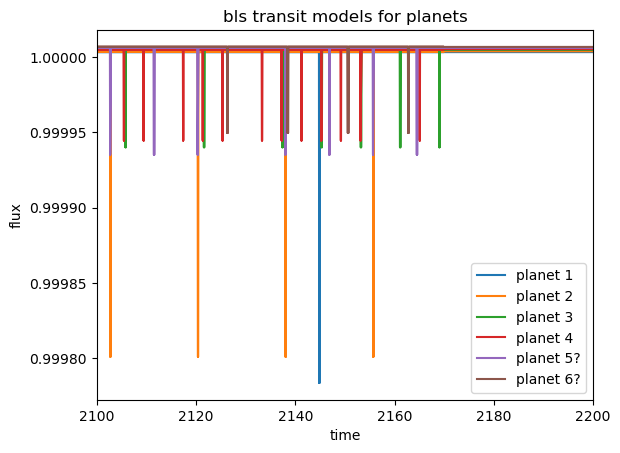

In [140]:
plt.plot(planet_1_model.time.value, planet_1_model.flux.value, label='planet 1')
plt.plot(planet_2_model.time.value, planet_2_model.flux.value, label='planet 2')
plt.plot(planet_3_model.time.value, planet_3_model.flux.value, label='planet 3')
plt.plot(planet_4_model.time.value, planet_4_model.flux.value, label='planet 4')
plt.plot(planet_5_model.time.value, planet_5_model.flux.value, label='planet 5?')
plt.plot(planet_6_model.time.value, planet_6_model.flux.value, label='planet 6?')

# plt.xlim(1335,1345)
# plt.xlim(1330,1350)
plt.xlim(2100,2200)
plt.title('bls transit models for planets')
plt.xlabel('time')
plt.ylabel('flux')
plt.legend()
plt.show()

# Fit Transit Times

In [158]:
from scipy.optimize import minimize
from scipy.optimize import root_scalar
from scipy.optimize import least_squares
from scipy.optimize import curve_fit

In [163]:
def omc(obs_time, t_num, p, tc):
    calc_time = tc + (t_num* p)
    omc = obs_time - calc_time
    return omc#*24 #days to hours

### Find the intersection points
def intersection_func(t,tc1,chi_sq, err_threshold): 
    return np.interp(t, tc1, chi_sq) - err_threshold

In [164]:
### stellar params
u1 = 0.496 # p/m 0.051
u2 = 0.210 # p/m 0.052

## Planet 1

In [165]:
### Planet params (from barros et al 2022)
per_1= 29.79749
rp_1= 0.0243
b_1= 0.785
T14_1= 2.94 * 0.0416667  # convert to days from hours


In [166]:
tc_guess_1 = transit_times_1
### get tc ranges for fit
tc_1 = []
for i in range(len(tc_guess_1)):
    start = tc_guess_1[i] - ttv_hour
    end = tc_guess_1[i] + ttv_hour
    t = np.linspace(start,end, 1000)
    tc_1.append(t)

In [167]:
### initialize arrays
tc_chi = np.zeros(len(tc_1))
tc_chi_parabola = np.zeros(len(tc_1))
ttv = np.zeros(len(tc_1))
ttv_p = np.zeros(len(tc_1))
errors = []
errors_p = []

In [170]:

def plot_chi_sq(time, flux, flux_err, tc, tc_guess, per, rp, b, T14, u1, u2):
    '''
    args:
        time: array of times from lightcurve
        flux: array of fluxes from lightcurve
        flux_err: array of flux errors from lightcurve
        tc: range of values around the guess time
        tc_guess: guess transit time
        per: period of planet
        rp: radius ratio (planet/star)
        b: impact parameter
        T14: transit duration
        u1, u2: limb darkening coefficients 
    '''
    ### plot X^2 vs tc for each guess
    for j in range(len(tc)):
        tc1 = tc[j]
        chi_sq = np.zeros(len(tc1))
        chi_sq_lc = np.zeros(len(tc1))
        for i in range(len(tc1)):
            t0_1 = 	tc1[i]
            theta_initial = [t0_1, per, rp, b, T14, u1, u2]
            
            ### initialize params
            params = batman.TransitParams()
            # params.t0, params.per, params.rp,params.b, params.T14, q1, q2 = theta_initial
            # params.u = [2*np.sqrt(q1)*q2, np.sqrt(q1)*(1-2*q2)]  # Limb darkening coefficients
            params.t0, params.per, params.rp,params.b, params.T14, u1, u2 = theta_initial
            params.u = [u1, u2] 
            params.limb_dark = 'quadratic'
            
            ### mask data - extract relevant photometry
            start = tc_guess[j] - ttv_hour
            end = tc_guess[j] + ttv_hour
            mask = (time > (start)) & (time < (end))
            
            transit_model = batman.TransitModel(params, time[mask])
                
            # Generate model light curve
            model_flux = transit_model.light_curve(params)
            
            # Calculate chi-squared value
            sigma2 = flux_err[mask] 
            chi_squared = np.sum(((flux[mask] - model_flux) / sigma2)**2)
            chi_sq[i] = (chi_squared)
    
        ### masked
        min_chi_time = tc1[np.argmin(chi_sq)]
        min_chi = chi_sq.min()
    
        tc_chi[j] = min_chi_time
        # idx = transit_num[j]
        ttv[j] = min_chi_time - tc_guess[j]
    
        chi_mask = (chi_sq <= min_chi + 3)
        fit_mask = (chi_sq <= min_chi + 1)
    
        ### fit parabola to the chisq
        p_chi_sq = np.polyfit(tc1[fit_mask], chi_sq[fit_mask], 2)  
    
        ### Extract the coefficients   y = ax^2 + bx + c
        a_chi_sq, b_chi_sq, c_chi_sq = p_chi_sq
        
        ### Find the minimum of the parabola xmin = -b/2a from taking derivative=0
        tc_best_fit = -b_chi_sq / (2 * a_chi_sq)
        
        ### Calculate the minimum chi-squared value
        chi_sq_min = a_chi_sq * tc_best_fit**2 + b_chi_sq * tc_best_fit + c_chi_sq
        tc_chi_parabola[j] = tc_best_fit
    
        ### Calculate the parabola best fit 
        p_1 = a_chi_sq*tc1**2 + b_chi_sq*tc1 + c_chi_sq
    
        ### calculate ttv from parabola fit 
        ttv_p[j] = tc_best_fit - tc_guess[j]
    
        ### delta chisq = 1 gives errors
        err_threshold = min_chi + 1 # using chisq discrete minimum
        err_threshold_p = chi_sq_min + 1 # using minimum of parabola
      
        # # Find the intersection using root_scalar
        # intersections = []
        # for k in range(len(tc1) - 1):
        #     if (chi_sq[k] - err_threshold) * (chi_sq[k + 1] - err_threshold) < 0:
        #         sol = root_scalar(intersection_func, bracket=[tc1[k], tc1[k + 1]], args=(tc1, chi_sq, err_threshold))
        #         if sol.converged:
        #             intersections.append((sol.root - min_chi_time))
        # errors.append(intersections)
    
        # intersections_p = []
        # for k in range(len(tc1) - 1):
        #     if (p_1[k] - err_threshold_p) * (p_1[k + 1] - err_threshold_p) < 0:
        #         sol = root_scalar(intersection_func, bracket=[tc1[k], tc1[k + 1]], args=(tc1, chi_sq, err_threshold))
        #         if sol.converged:
        #             intersections_p.append((sol.root - tc_best_fit))
        # errors_p.append(intersections_p)
    
        plt.plot(tc1[chi_mask], chi_sq[chi_mask],label='chisq')
        plt.plot(tc1[chi_mask], p_1[chi_mask],label='chisq parabola', color='orange')
        plt.axvline(x=tc_guess[j], color='r', linestyle='--', label='Bls Guess')
        plt.axvline(x=min_chi_time, linestyle='--', label='Chisq min')
        plt.axvline(x=tc1[np.argmin(p_1)], color='orange', linestyle='--', label='Chisq min parabola')
    
        # for inter in intersections:
        #     plt.axvline(x=inter, color='blue', linestyle='--')
        plt.axhline(y=err_threshold, color='green', linestyle='--', label='Error Threshold')
        plt.title(f'Transit {j+1}: Planet b')
        plt.xlabel('tc')
        plt.ylabel('X^2')
        plt.legend()
        plt.show()

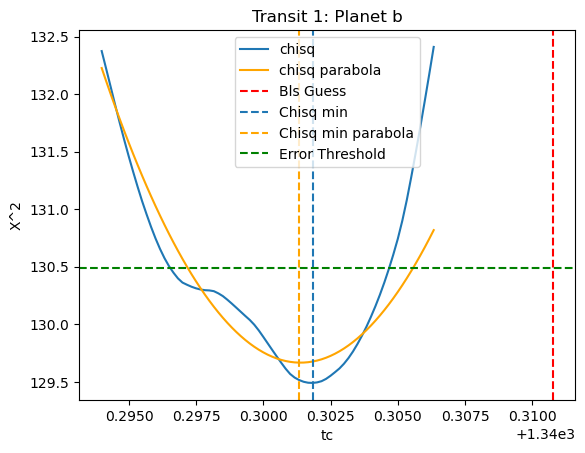

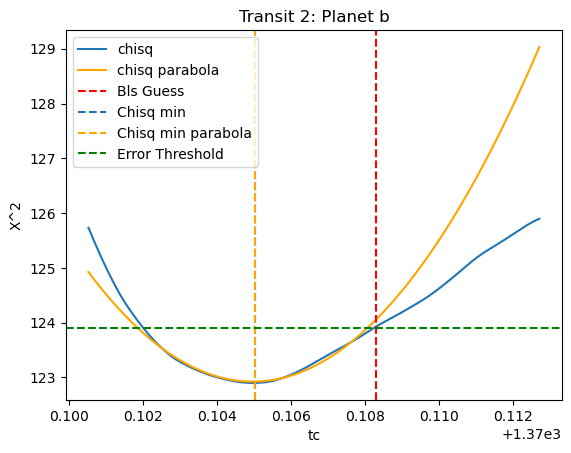

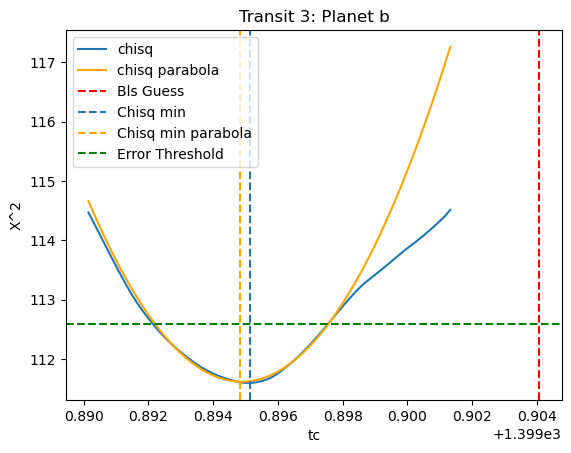

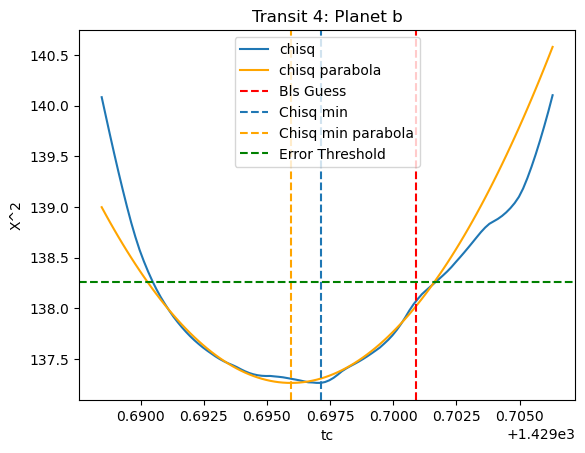

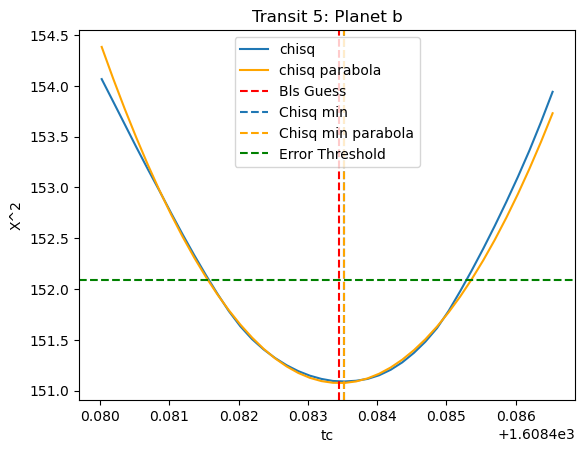

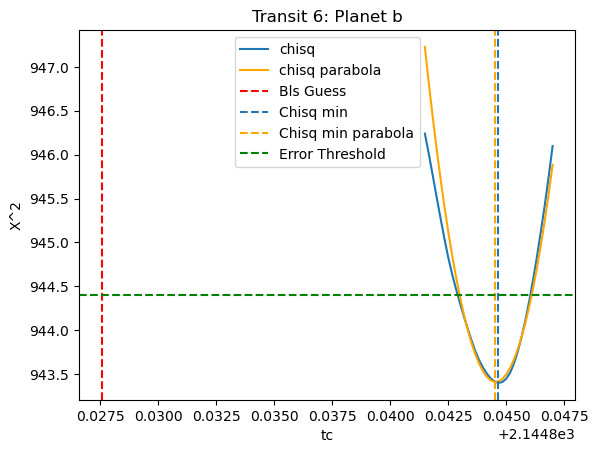

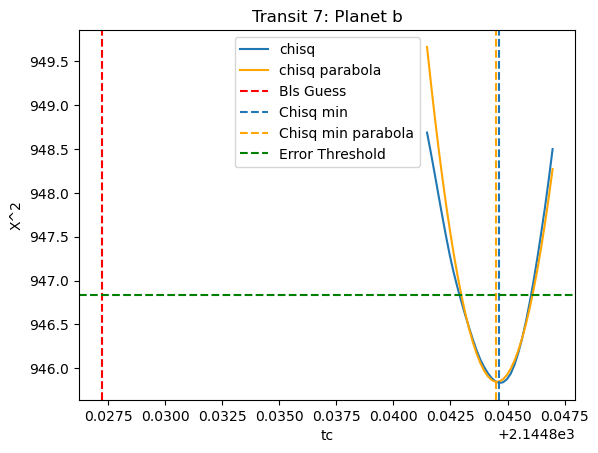

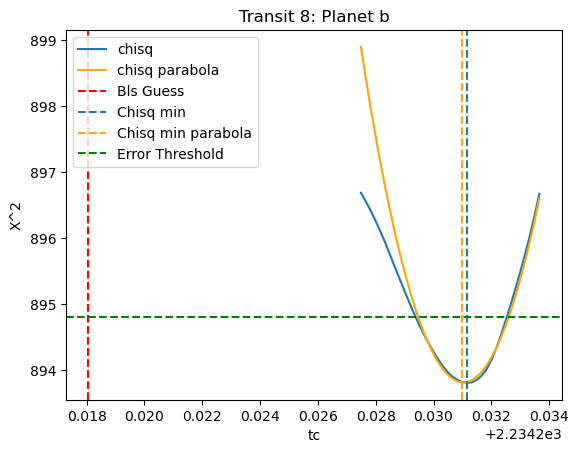

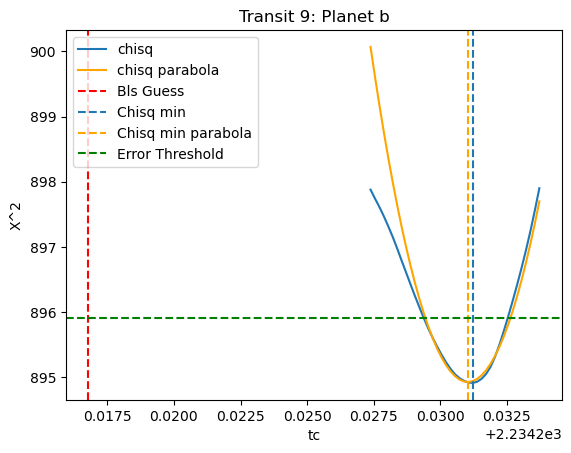

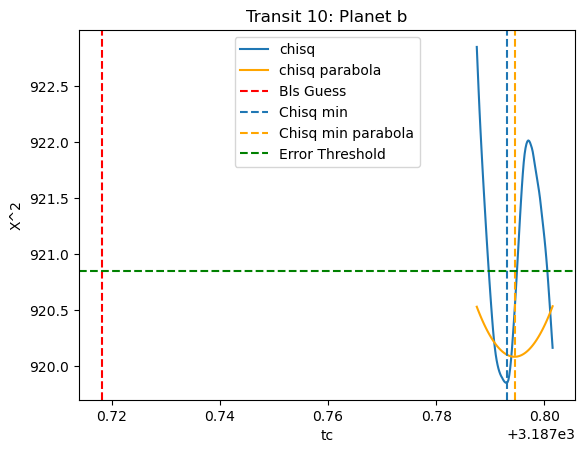

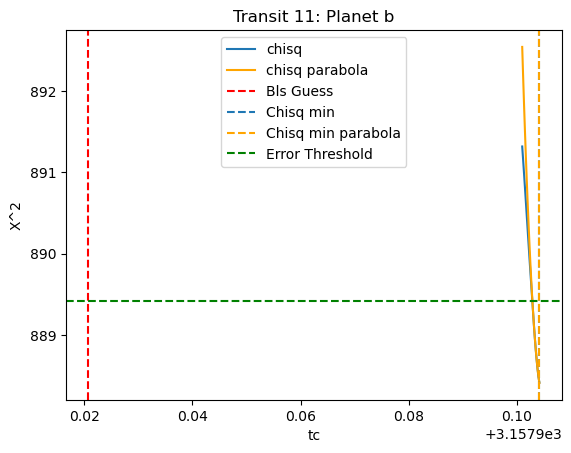

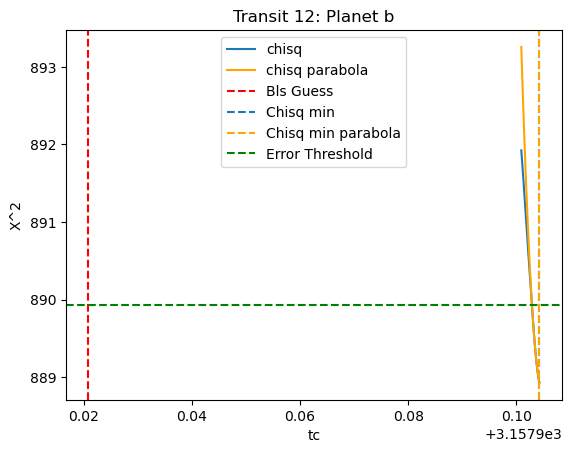

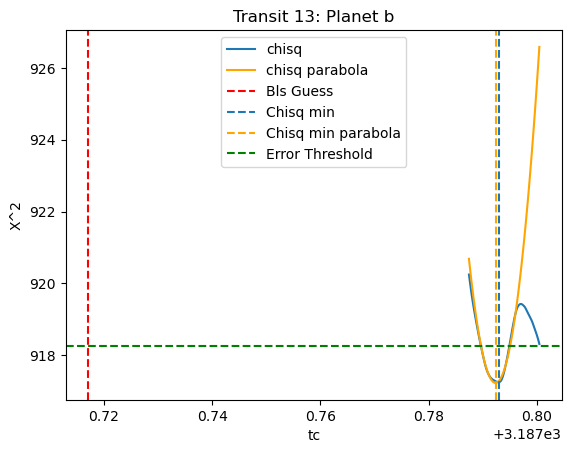

In [171]:
plot_chi_sq(time, flux, flux_err, tc_1, tc_guess_1, per_1, rp_1, b_1, T14_1, u1, u2)

In [172]:
print(tc_chi)

[1340.3018256  1370.10503759 1399.89515009 1429.69713161 1608.48352817
 2144.84465508 2144.84464153 2234.23115886 2234.23122041 3187.79300913
 3158.00411135 3158.00422709 3187.79296846]


In [174]:
# Transit windows
buffer = 1.5 * T14_1
transit_times_1 = tc_chi

In [195]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.ticker import FuncFormatter
import batman

def plot_transits(transit_times, per, rp, b, T14, u1, u2):
    cols = 3
    rows = int(np.ceil(len(transit_times) / cols))
    
    fig = plt.figure(figsize=(14, rows * 2.8))
    outer = gridspec.GridSpec(rows, cols, figure=fig, wspace=0.3, hspace=0.5)
    
    for i, t0 in enumerate(transit_times):
        row = i // cols
        col = i % cols
        inner = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=outer[row, col],
                                                 height_ratios=[3, 1], hspace=0.0)  # Panels touch
    
        t_min = t0 - buffer
        t_max = t0 + buffer
        mask = (time >= t_min) & (time <= t_max)
        time_rel = time[mask] - t0  # Time relative to Tc
    
        # Transit model setup
        theta_initial = [t0, per, rp, b, T14, u1, u2]
        params = batman.TransitParams()
        params.t0, params.per, params.rp, params.b, params.T14, u1, u2 = theta_initial
        params.u = [u1, u2]
        params.limb_dark = 'quadratic'
    
        m = batman.TransitModel(params, time[mask])
        model_flux = m.light_curve(params)
        residuals = flux[mask] - model_flux
    
        # Top panel: model + data
        ax1 = fig.add_subplot(inner[0])
        ax1.scatter(time_rel, flux[mask], s=5, label='Data')
        ax1.plot(time_rel, model_flux, color='red', label='Model')
        ax1.axvline(0, color='green', linestyle='--', label='Tc')
        ax1.set_xlim(-buffer, buffer)
        ax1.set_title(f'Tc = {round(t0, 3)} (BJD-{TESS_offset})')
        ax1.grid(True)
        ax1.tick_params(labelbottom=False)
    
        # Bottom panel: residuals
        ax2 = fig.add_subplot(inner[1], sharex=ax1)
        ax2.scatter(time_rel, residuals, s=5)
        ax2.axhline(0, color='red', linestyle='--', linewidth=1)
        ax2.set_xlim(-buffer, buffer)
        ax2.set_xlabel("Time from Tc [days]")
        ax2.grid(True)
    
        # Y-axis labels for first column only
        if col == 0:
            ax1.set_ylabel("Flux")
            ax2.set_ylabel("Residuals")
        else:
            ax1.set_ylabel("")
            ax1.tick_params(labelleft=False)
            ax2.set_ylabel("")
            ax2.tick_params(labelleft=False)
    
        # Custom ticks
        ticks = np.round(np.linspace(-buffer, buffer, 4), 2)
        ax2.set_xticks(ticks)
    
    plt.show()


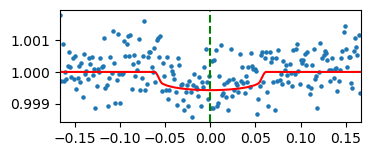

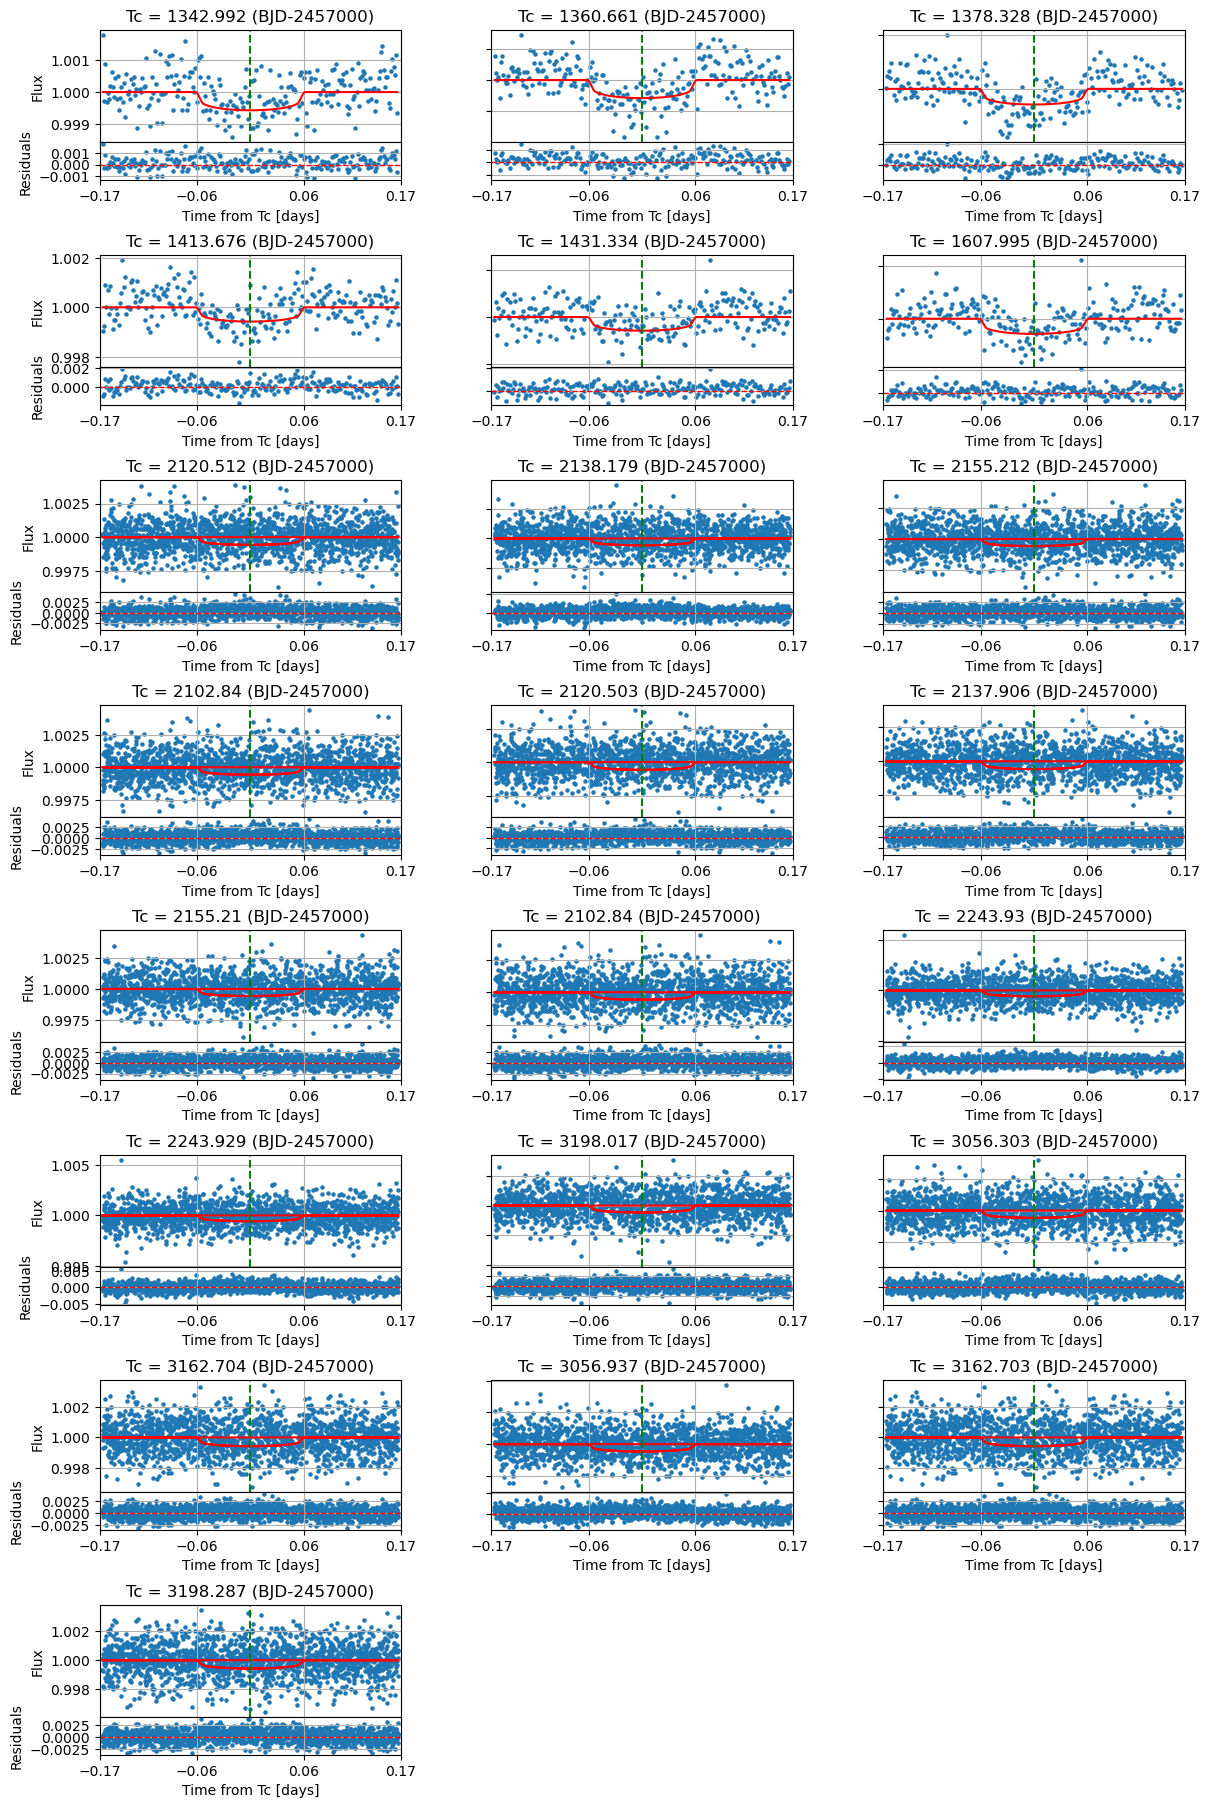

In [196]:
plot_transits(transit_times_1, per_1, rp_1, b_1, T14_1, u1, u2)

## Planet 2

In [178]:
### Planet params (from barros et al 2022)
per_2= 17.667087
rp_2= 0.02597
b_2= 0.690
T14_2= 2.67 * 0.0416667  # convert to days from hours


In [187]:
tc_guess_2 = transit_times_2
### get tc ranges for fit
tc_2 = []
for i in range(len(tc_guess_2)):
    start = tc_guess_2[i] - 6*ttv_hour
    end = tc_guess_2[i] + 6*ttv_hour
    t = np.linspace(start,end, 1000)
    tc_2.append(t)

In [188]:
### initialize arrays
tc_chi = np.zeros(len(tc_2))
tc_chi_parabola = np.zeros(len(tc_2))
ttv = np.zeros(len(tc_2))
ttv_p = np.zeros(len(tc_2))
errors = []
errors_p = []

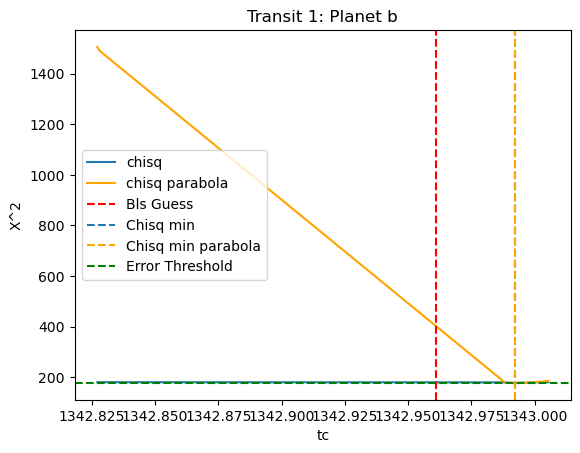

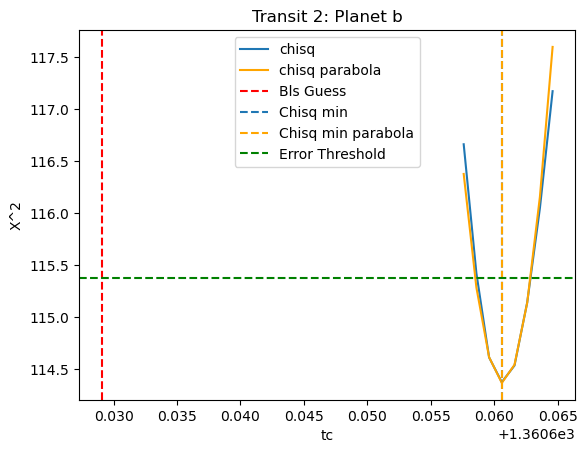

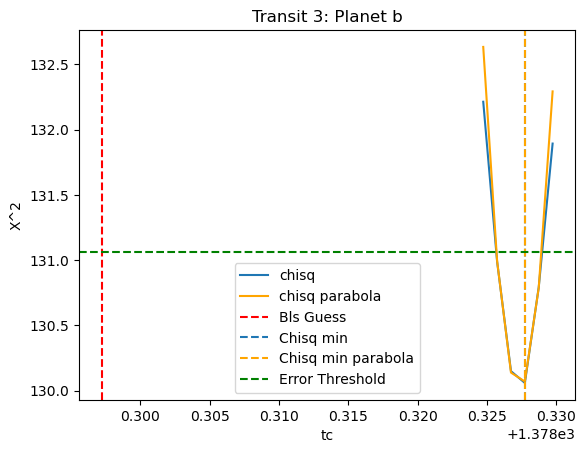

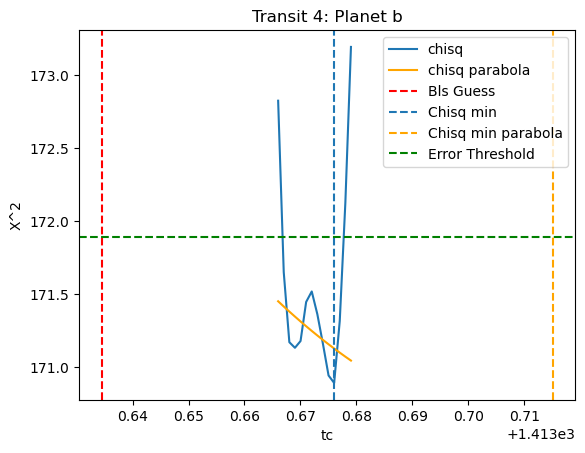

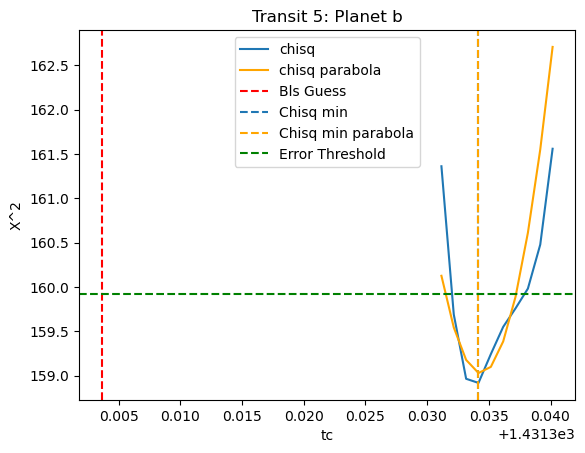

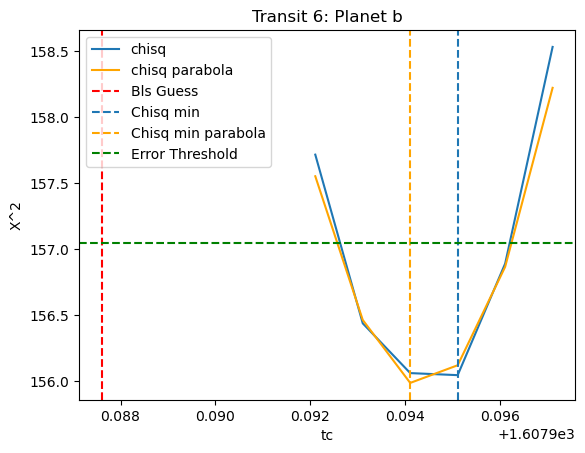

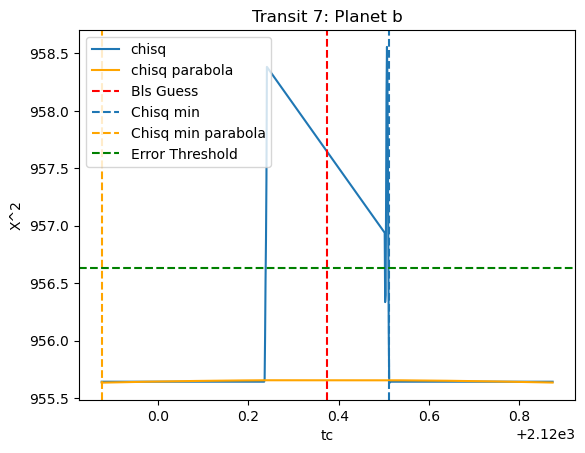

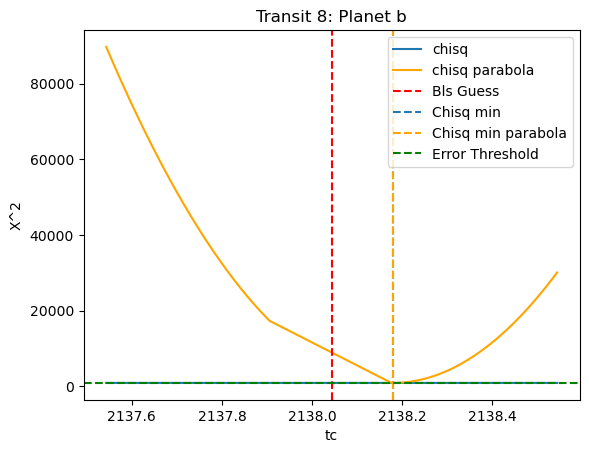

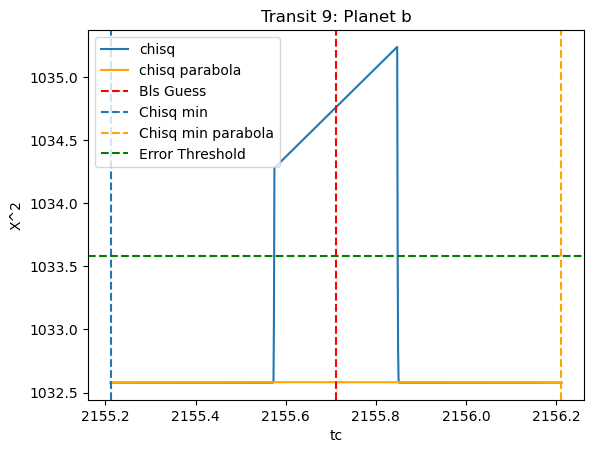

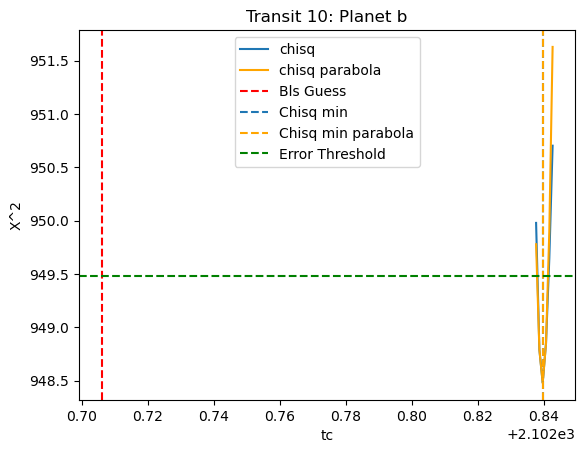

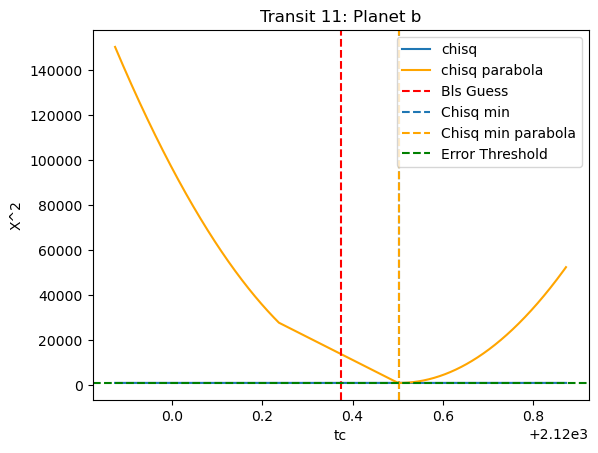

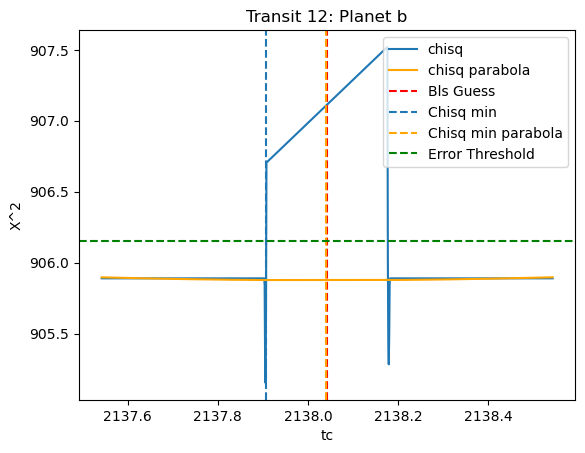

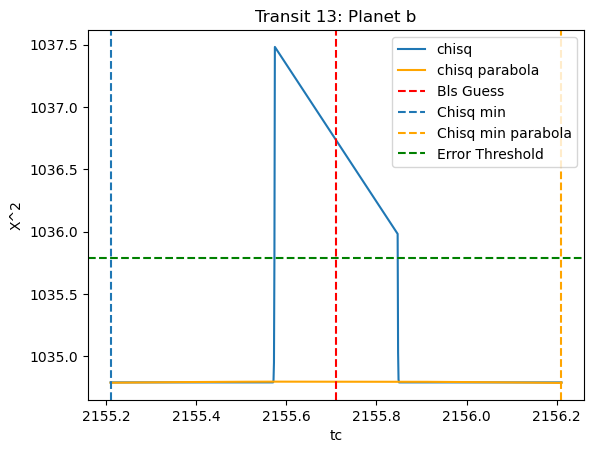

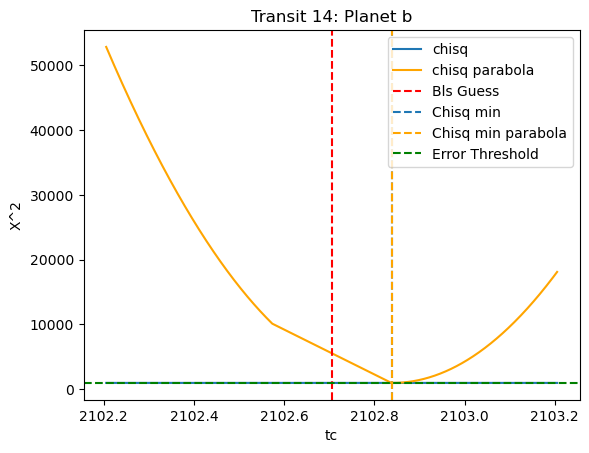

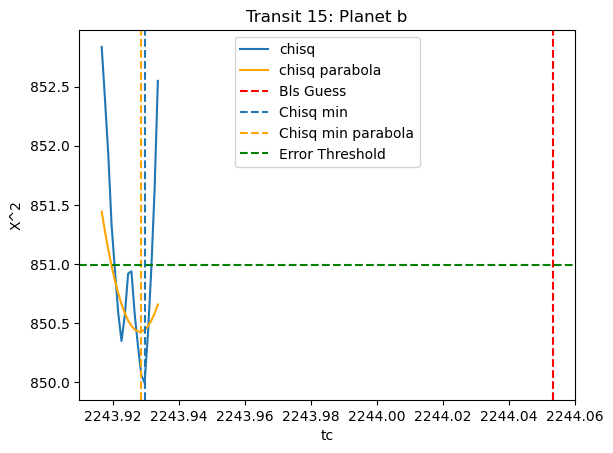

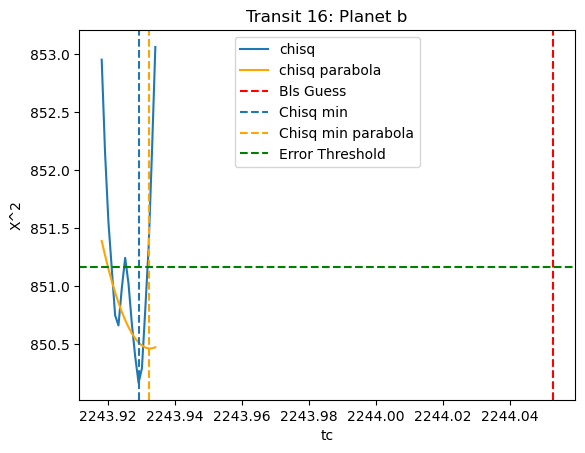

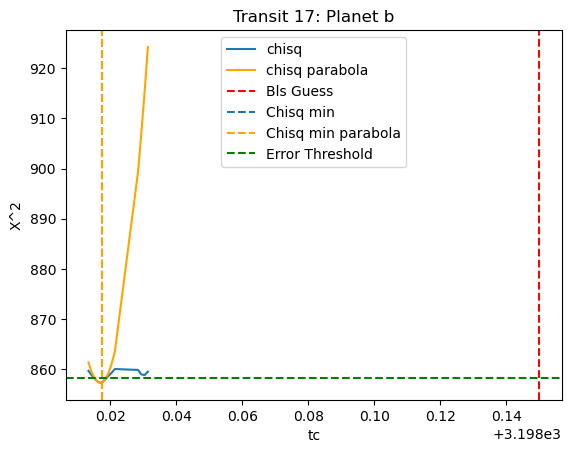

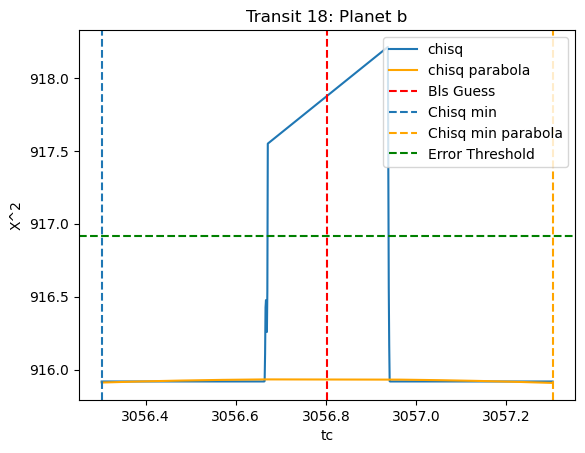

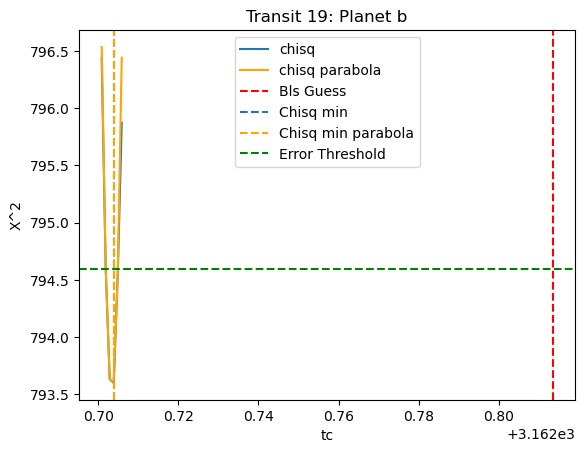

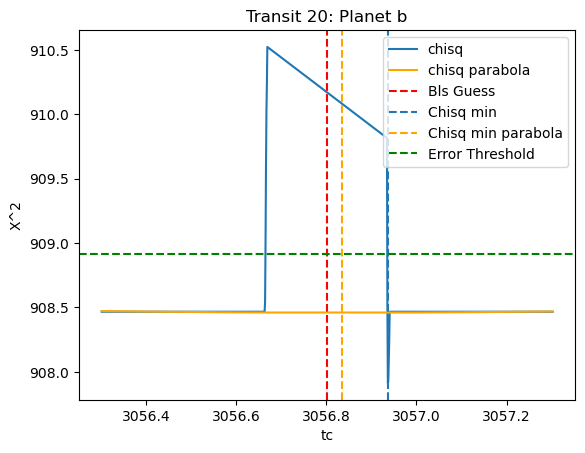

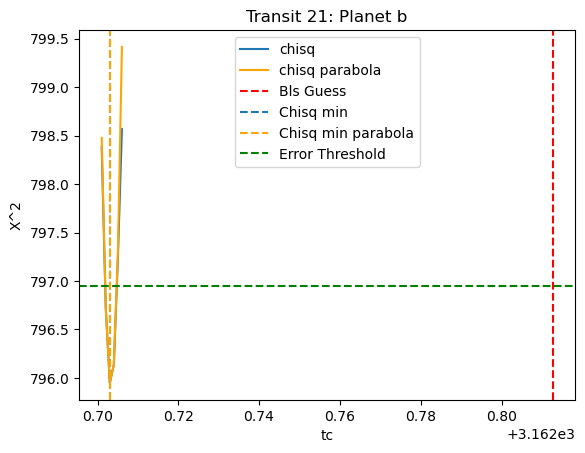

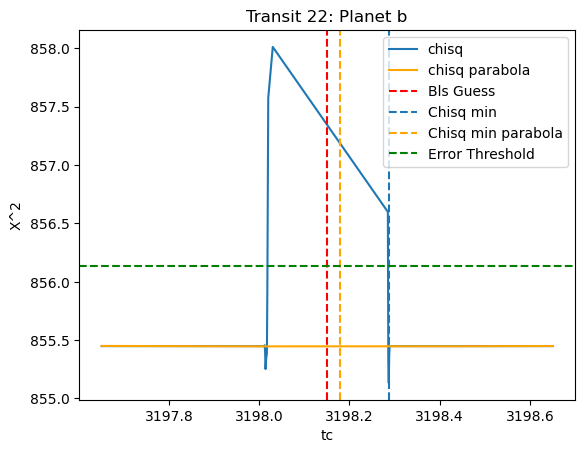

In [189]:
plot_chi_sq(time, flux, flux_err, tc_2, tc_guess_2, per_2, rp_2, b_2, T14_2, u1, u2)

In [190]:
print(tc_chi)

[1342.99232766 1360.66059522 1378.32773902 1413.67602666 1431.33416286
 1607.9951109  2120.51217148 2138.17901344 2155.21163546 2102.83964602
 2120.50289032 2137.90593077 2155.21036234 2102.83983683 2243.92964284
 2243.92906415 3198.01732827 3056.3028413  3162.70384739 3056.93666624
 3162.70303719 3198.28717646]


In [191]:
# Transit windows
buffer = 1.5 * T14_2
transit_times_1 = tc_chi

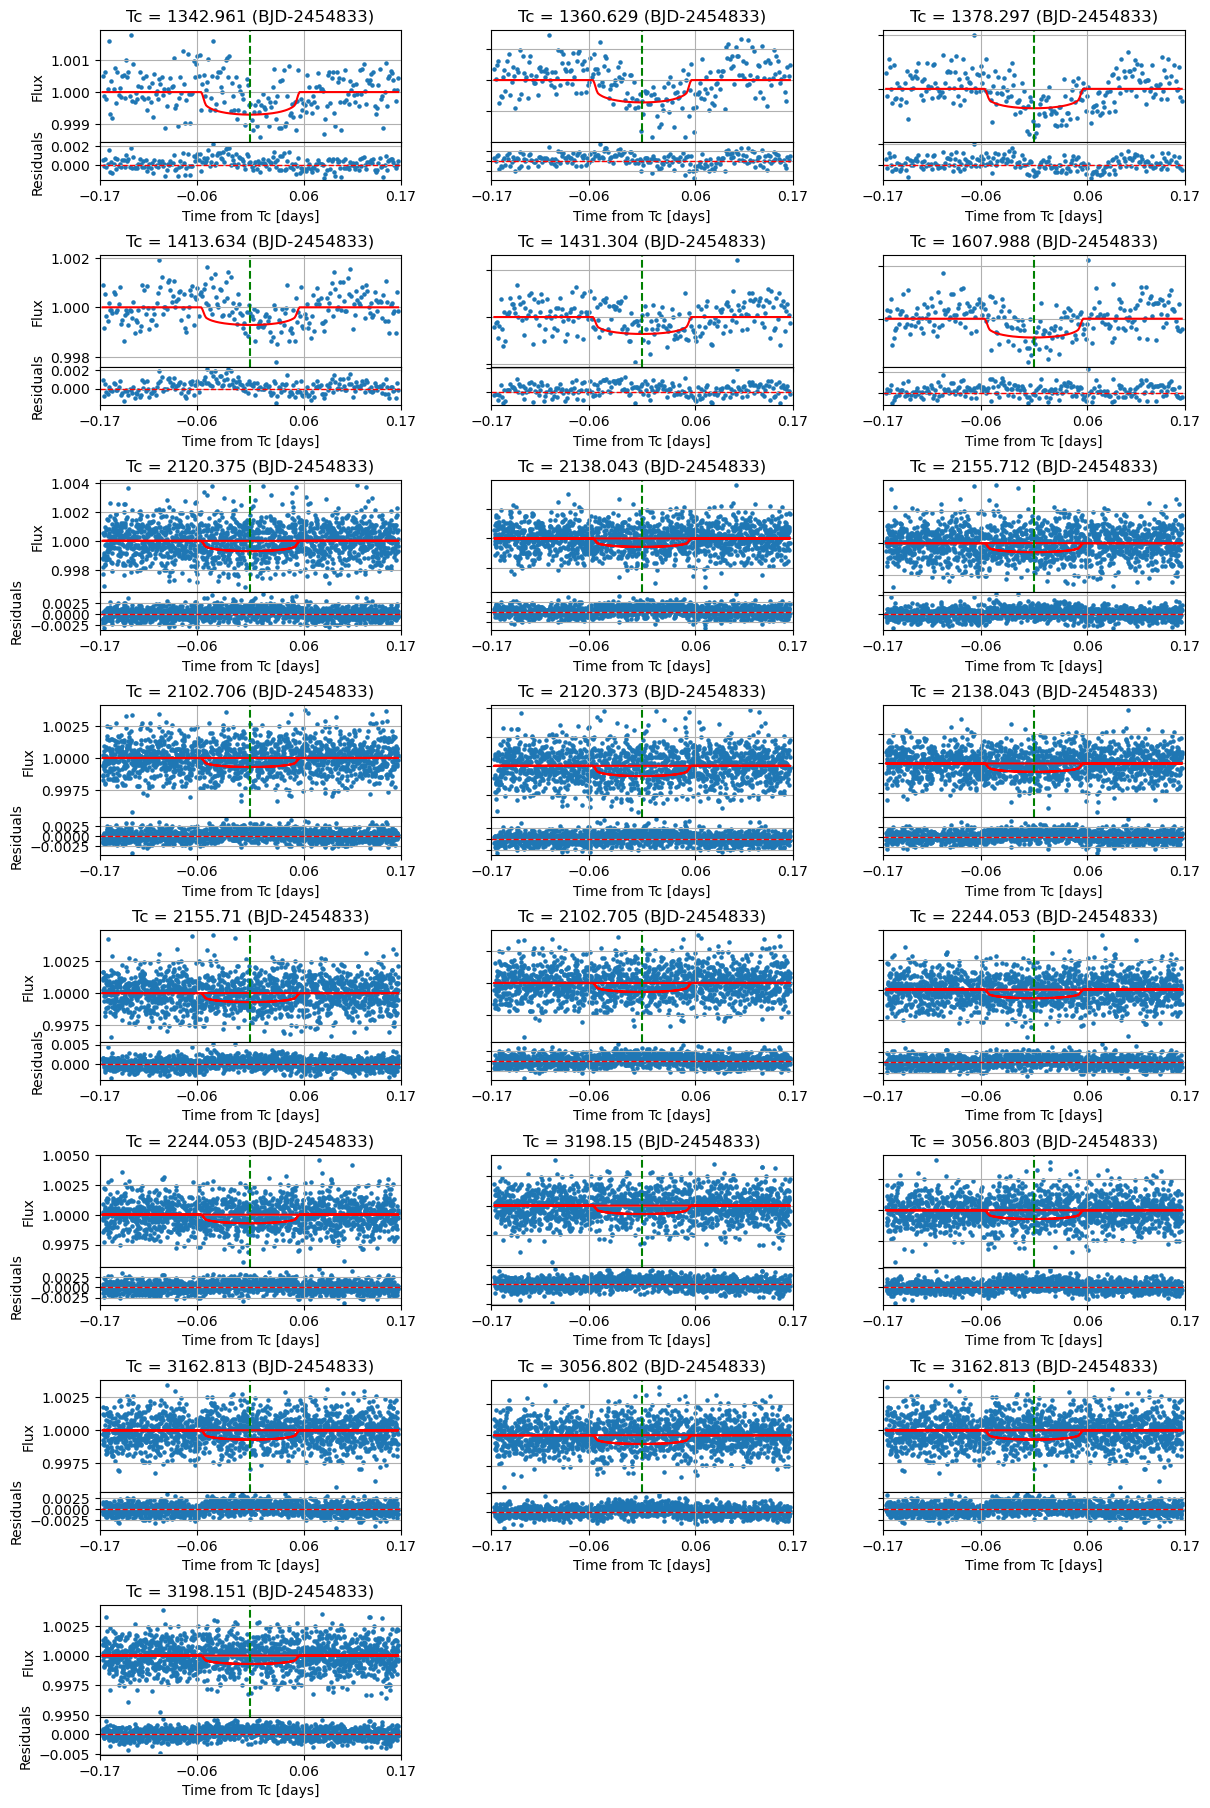

In [192]:
plot_transits(transit_times_2, per_2, rp_2, b_2, T14_2, u1, u2)